In [1]:
import numpy as np
import itk
import matplotlib.pyplot as plt
import skimage.io as io


# Basic test

In [2]:
imgA=itk.imread('sliceA.tif')
imgB=itk.imread('sliceB.tif')
med=itk.MedianImageFilter.New(imgA,radius=2)

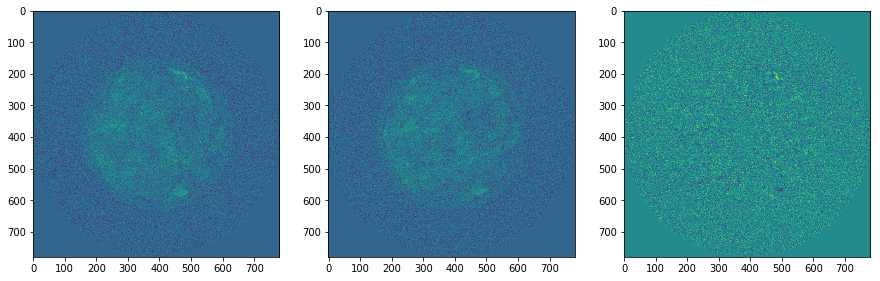

In [3]:
plt.figure(figsize=[15,6])
plt.subplot(131)
plt.imshow(itk.GetArrayFromImage(imgA),clim=[5000,40000])
plt.subplot(132)
plt.imshow(itk.GetArrayFromImage(imgB),clim=[5000,40000])
plt.subplot(133)
plt.imshow(itk.GetArrayFromImage(imgA).astype('float32')-itk.GetArrayFromImage(imgB).astype('float32'))

# Registration test

In [10]:
import SimpleITK as sitk
import sys

In [5]:
def command_iteration(method) :
    print("{0:3} = {1:7.5f} : {2}".format(method.GetOptimizerIteration(),
                                           method.GetMetricValue(),
                                           method.GetOptimizerPosition()))

## Load data

In [7]:
pixelType = sitk.sitkFloat32

fixed = sitk.ReadImage("sliceA.tif", sitk.sitkFloat32)
fixed = sitk.Normalize(fixed)
#fixed = sitk.DiscreteGaussian(fixed, 1.0)
fixed = sitk.Median(fixed,[2,2])
fixedSpacing=fixed.GetSpacing()
fixedOrigin  = fixed.GetOrigin() 
# fixedRegion  = fixed.GetLargestPossibleRegion(); 
# fixedSize    = fixedRegion.GetSize()

moving = sitk.ReadImage("sliceB.tif", sitk.sitkFloat32)
moving = sitk.Normalize(moving)
#moving = sitk.DiscreteGaussian(moving, 1.0)
moving = sitk.Median(moving,[2,2])

## Initialize

In [11]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsJointHistogramMutualInformation()

R.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0,
                                          numberOfIterations=200,
                                          convergenceMinimumValue=1e-5,
                                          convergenceWindowSize=5)

R.SetInitialTransform(sitk.CenteredTransformInitializer(fixed, 
                                                      moving, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY))
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

0

In [9]:
outTx = R.Execute(sitk.DiscreteGaussian(fixed, 1.0), sitk.DiscreteGaussian(moving, 1.0))

print("-------")
print(outTx)
print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))


sitk.WriteTransform(outTx,  "mat.txt")

  0 = -0.85661 : (-0.002232593998454091, 9.486195307626085e-06, 4.4498452903443786e-05)
  1 = -0.85852 : (-0.013201476613100633, 6.146060502802848e-05, 0.0002646009815890075)
  2 = -0.86741 : (-0.06385704381247395, 0.0004166753021517243, 0.0013630655154135067)
  3 = -0.89436 : (-0.0811425315422071, 0.0027225305715343037, 0.0071077556111749565)
  4 = -0.89609 : (-0.07954082381233145, 0.002758958229087713, 0.007223975431142208)
  5 = -0.89612 : (-0.07931466178403189, 0.0027647921794666346, 0.007242160646749988)
  6 = -0.89611 : (-0.07929477451693358, 0.0027653152668286585, 0.007243789558979158)
  7 = -0.89611 : (-0.07926335729594042, 0.0027661435515301865, 0.007246364532876392)
-------
itk::simple::Transform
 Euler2DTransform (0x7fd05e2c13a0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 2
   Modified Time: 48554
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.996856 0.0792315 
     -0.0792315 0.996856 
   Offset: [-2.0125, 2.18903]
   C

## Show results

Text(0.5, 1.0, 'Combined')

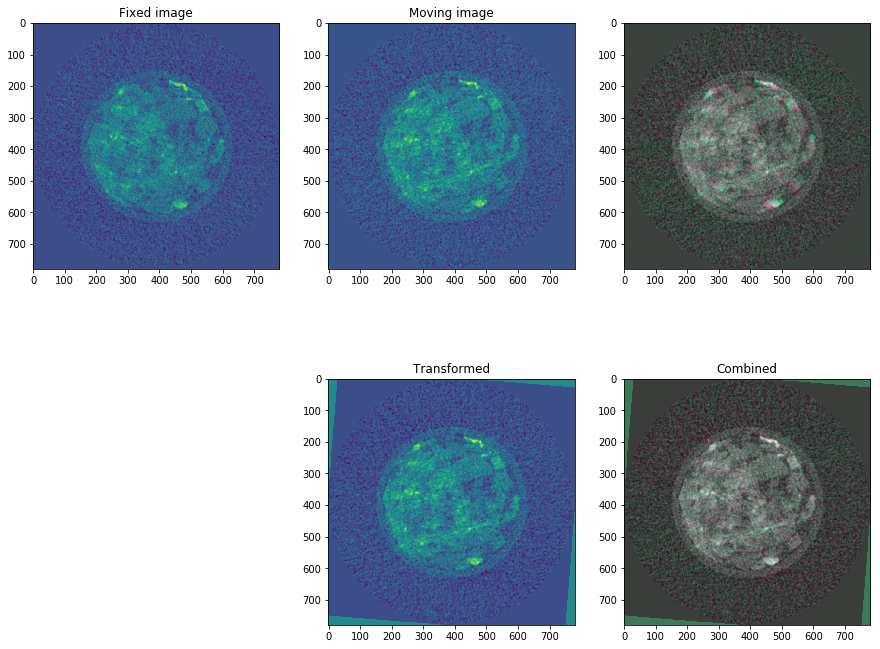

In [189]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg_fixed = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg_moving = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
simg_out = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg_orig = sitk.Compose(simg_fixed, simg_moving, simg_fixed//2.+simg_moving//2.)
cimg  = sitk.Compose(simg_fixed, simg_out, simg_fixed//2.+simg_out//2.)

npfixed  = sitk.GetArrayFromImage(fixed).copy().astype('float')

npmoving = sitk.GetArrayFromImage(moving).copy().astype('float')
npout    = sitk.GetArrayFromImage(out).copy().astype('float')
plt.figure(figsize=[15,12])
plt.subplot(231)
plt.imshow(npfixed)
plt.title('Fixed image')

plt.subplot(232)
plt.imshow(npmoving)
plt.title('Moving image')
plt.subplot(233)
plt.imshow(sitk.GetArrayFromImage(cimg_orig))

plt.subplot(235)
plt.imshow(npout)
plt.title('Transformed')
plt.subplot(236)
plt.imshow(sitk.GetArrayFromImage(cimg))
plt.title('Combined')


## Inspect bivariate histograms

Text(0.5, 1.0, 'Histogram after transform')

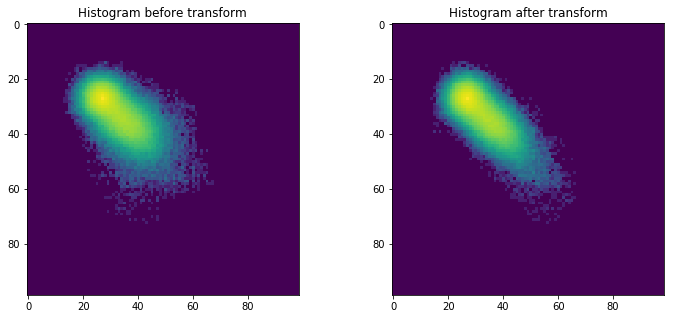

In [195]:
plt.figure(figsize=[12,5])
plt.subplot(121)
xedges = np.linspace(-3.0,7.0,100)
yedges = np.linspace(-3.0,7.0,100)
H,xax,yax = np.histogram2d(npfixed[100:650,100:650].ravel(),npmoving[100:650,100:650].ravel(),bins=(xedges,yedges))
plt.imshow(np.log(H+1))
plt.title('Histogram before transform')
plt.subplot(122)
xedges = np.linspace(-3.0,7.0,100)
yedges = np.linspace(-3.0,7.0,100)
H,xax,yax = np.histogram2d(npfixed[100:650,100:650].ravel(),npout[100:650,100:650].ravel(),bins=(xedges,yedges))
plt.imshow(np.log(H+1))
plt.title('Histogram after transform')

# 3D

In [196]:
fixed = sitk.ReadImage("/data/P20170229/04_evaluation/filtered_0000/frame0000_vol.tif", sitk.sitkFloat32)

In [197]:
fixed.GetSize()

(780, 780, 650)